In [1]:
import torch
from torch import nn
import circuits as ckt
import learn as lrn
import models as mdl

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Circuit

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': -1, 'v': None, 'attr': 1}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': None})]


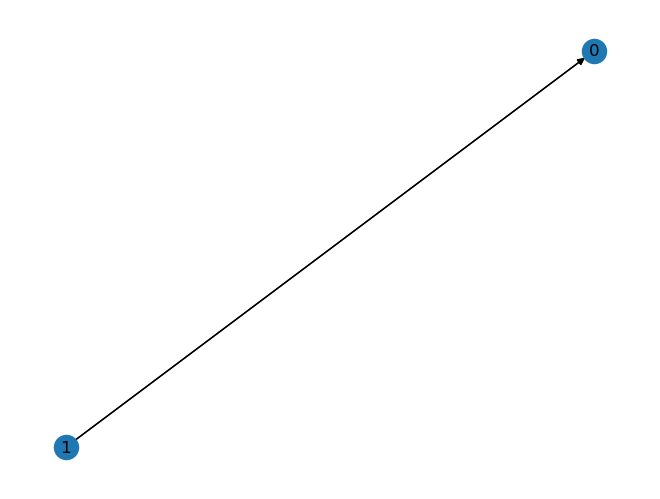

In [3]:
vr = ckt.Circuit()
v_source = vr.add_element(kind=ckt.Kinds.IVS)
resistor = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, resistor.high)
v_source.connect(v_source.low, resistor.low)
v_source.attr = 1
v_source.i = -1
# resistor.i = 0.1
# resistor.attr = 4
print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Convert Circuit to Model Input

In [4]:
input = ckt.Input(vr)

Kinds.IVS
Kinds.R


c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:66: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [5]:
input.M

tensor([[-1., -1.],
        [ 1.,  1.]])

In [6]:
input.kinds_map

{<Kinds.IVS: 0>: [True, False],
 <Kinds.ICS: 1>: [False, False],
 <Kinds.R: 2>: [False, True]}

In [7]:
input.knowns_map

{<Props.I: 0>: [True, False],
 <Props.V: 1>: [True, False],
 <Props.Attr: 2>: [True, False]}

In [8]:
input.inputs_map

{<Props.I: 0>: [-1.0, 0.8381185745493608],
 <Props.V: 1>: [1.0, 0.5157238488483558],
 <Props.Attr: 2>: [1.0, 0.5178581700417973]}

In [9]:
input.init_params()

(Parameter containing:
 tensor([[-1.0000],
         [ 0.8381]], requires_grad=True),
 Parameter containing:
 tensor([[1.0000],
         [0.5157]], requires_grad=True),
 Parameter containing:
 tensor([[0.1521],
         [0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[1.0000],
         [0.5179]], requires_grad=True))

# Training

In [10]:
num_epochs = 100
threshhold = 0.1
state = 0
max_state = 2
prev_loss = 0.1
params_glob = input.init_params()
init_model = mdl.KCL(input,params_glob).to(device)
init_opt = torch.optim.Adam(params=init_model.parameters(),lr=0.1)
loss, params_glob = lrn.train(init_model,init_opt,nn.MSELoss())
print(f'init params: {params_glob}')
print(f'init state {state} loss: {loss.item()}')
epoch = 0

while(epoch < num_epochs):
    if  (state == 0):
        loss,state = lrn.process_state(params_glob,input,mdl.KCL,state,
                                              max_state=max_state,device=device,
                                              threshold = threshhold)
    elif(state == 1):
        loss,state = lrn.process_state(params_glob,input,mdl.KVL,state,
                                              max_state=max_state,device=device,
                                              threshold = threshhold)
    elif(state == 2):
        loss,state = lrn.process_state(params_glob,input,mdl.Full,state,
                                              max_state=max_state,device=device,
                                              threshold = threshhold)
        threshhold /= 10
        if(loss < 1e-3):
            break
    else:
        assert()

    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes')
print(f"current = {params_glob[0]}")
print(f"voltage = {params_glob[1]}")
print(f"potential = {params_glob[2]}")
print(f"attributes = {params_glob[3]}")

init params: (Parameter containing:
tensor([[-1.0000],
        [ 0.9381]], requires_grad=True), tensor([[1.0000],
        [0.5157]]), tensor([[0.3622],
        [0.9998]]), tensor([[1.0000],
        [0.5179]]))
init state 0 loss: 0.026205603033304214
Done! at 2 passes
current = Parameter containing:
tensor([[-1.0000],
        [ 1.0000]], requires_grad=True)
voltage = tensor([[1.0000],
        [1.0000]])
potential = tensor([[0.1810],
        [1.1810]])
attributes = tensor([[1.0000],
        [1.0000]])
